## Lab 8 – Dealing with Overfitting
- MNIST dataset
  - Handwritten digits images
  - 28 x 28 greyscale
- Source: https://www.cs.toronto.edu/~lczhang/360/lec/w05/overfit.html

### Load the data into training and validation sets
- for purposes of overfitting, training data will be largely reduced
- no normalisation is applied yet
- `batch_size` is set to 20
- we will also **NOT** use GPU

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

batch_size = 20

# for reproducibility
torch.manual_seed(1)

train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_data = list(train_data)
train_set = train_data[:20]     # 20 images
val_set   = train_data[200:2200]# 2000 images

train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### View a few images

torch.Size([20, 1, 28, 28])
tensor([1, 6, 3, 1, 1, 8, 3, 1, 3, 0, 9, 5, 9, 6, 2, 7, 2, 4, 5, 4])
class labels: tensor([1, 6, 3, 1, 1, 8, 3, 1, 3, 0, 9, 5, 9, 6, 2, 7, 2, 4, 5, 4])


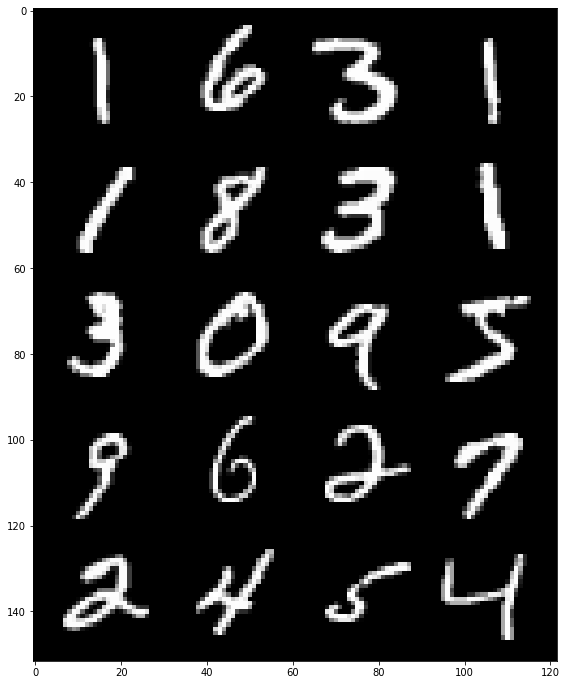

In [ ]:
batch = next(iter(train_loader))

images, labels = batch

print(images.shape)
print(labels)

# Create a grid
plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

### Create a NN model

In [ ]:
class MNIST_DNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
    def forward(self, img):
        flattened = img.reshape(-1, 28 * 28)
        out1 = F.relu(self.layer1(flattened))
        out2 = F.relu(self.layer2(out1))
        output = self.layer3(out2)
        return output

### Function to Calculate Accuracy

In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() # For later #
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total


## Function for Training Loop
- We will run over 500 iterations in batches of 20


In [ ]:
def train_model(model, train, valid, n_iters=500, learn_rate=0.01, weight_decay=0):
  # Lists to store model's performance information
  iters, losses, train_acc, val_acc = [], [], [], []

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

  for i in range(n_iters):
    for images, labels in iter(train_loader):
      model.train() # For Dropout and Batch Norm layers #
      out = model(images)           # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      optimizer.step()              # make the updates for each parameter
      optimizer.zero_grad()         # reset the gradients for the next iteration

      # Save the current training and validation information at every 10th iteration
      if (i+1) % 10 == 0:
          iters.append(i)
          losses.append(float(loss)/batch_size)        # compute *average* loss
          train_acc.append(get_accuracy(model, train)) # compute training accuracy
          val_acc.append(get_accuracy(model, valid))   # compute validation accuracy


  print(f'Plotting')
  # Plotting Training Loss, Accuracy and Validation Accuracy
  plt.figure(figsize=(10,4))
  plt.subplot(1,2,1)
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")

  plt.subplot(1,2,2)
  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Build A Basic Model
- uses 20 images for training data, contained in `train_set`
- uses 2000 images for validation data, contained in `val_set`
- trains over 500 iterations

Plotting


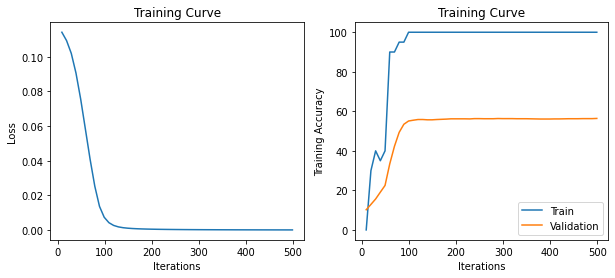

Final Training Accuracy: 100.0
Final Validation Accuracy: 56.4


In [ ]:
model = MNIST_DNN()
train_model(model, train_set, val_set)

In [ ]:
# Based on the plotted graphs, answer the following questions:

# Q1. What is the final loss of the training set and at which iteration was this achieved?

# The final loss of the training set is 0% and was achieved a the 120th
# iteration.

# Q2. What is the final accuracy of the training set and at which iteration was this achieved?

# The final accuracy of the training set is 100% and was achieved at around the
# 120th iteration.

# Q3. What do these values tell you about the model's performance on the training data?

# The model worked well on the training data since the loss is 0% and the
# accuracy is 100%.

# Q4. What is the model's final accuracy on the validation set?

# The model's final accuracy on the validation set is 56.4%.

# Q5. Would more iterations help make a better model? Why or why not?

# No. The model is already at 100% accuracy. More iterations would enforce
# overfitting of the model. Adding more iterations would add more data points
# which will reinforce overfitting in the model.

# Q6. Would this model work well on classifying other handwritten digits? Why or why not?

# No. This model was trained to work well on this set of dataset with a high
# accurracy and zero loss. Therefore, when introduced other datasets of
# handwritten digits, the model would not perform as well.


### Add Normalisation and Weight Decay
- Our basic model gets to around 52-55% accuracy on the validation set.
- Normalisation will ensure the spread of the values are within a certain range. For example, normalising with mean value 0.5 and std 0.5 subtracts mean (0.5) from each pixel, and divides the result by std (0.5). So, each pixel intensity will be in the range `[-1, 1]`.
- Weight decay penalises large weights. We avoid large weights because large weights mean that the prediction relies a lot on the content of one pixel, or on one unit. Intuitively, the classification of an image should NOT depend heavily on the content of one pixel, or even a few pixels.





In [ ]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# for reproducibility
torch.manual_seed(1)

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_data = list(train_data)
train_set = train_data[:20]     # 20 images
val_set   = train_data[200:2200]# 2000 images

train_loader = torch.utils.data.DataLoader(train_set,
                                               batch_size=batch_size,
                                               shuffle=True) # shuffle after every epoch


### Train a model with Normalisation and Weight Decay

Plotting


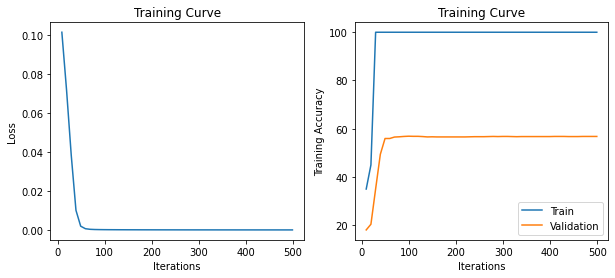

Final Training Accuracy: 100.0
Final Validation Accuracy: 56.8


In [ ]:
model = MNIST_DNN()
train_model(model, train_set, val_set, weight_decay=0.001)

### Dropouts
- Randomly "zero out", or "remove" a portion of neurons from each training iteration
- In different iterations of training, we will drop out a different set of neurons
- Prevents weights from being overly dependent on each other, e.g. one weight could be unnecessarily large to compensate for another unnecessarily large weight with the opposite sign. Weights are encouraged to be "more independent" of one another
- During validation, we will not drop out any neurons. This means that our training time and test time behaviour of dropout layers are different. In the code for the functions `train_model()` and `get_accuracy()`, we use `model.train()` and `model.eval()` to flag whether we want the model's training behaviour, or test time behaviour.

In [ ]:
class MNIST_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout = nn.Dropout(0.4) # drop out layer with 40% dropped out neuron
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        layer1 = self.dropout(F.relu(self.layer1(flattened)))
        layer2 = self.dropout(F.relu(self.layer2(layer1)))
        output = self.layer3(layer2)
        return output

### Build a new model with Dropouts
- In addition to normalisation and weight decay

Plotting


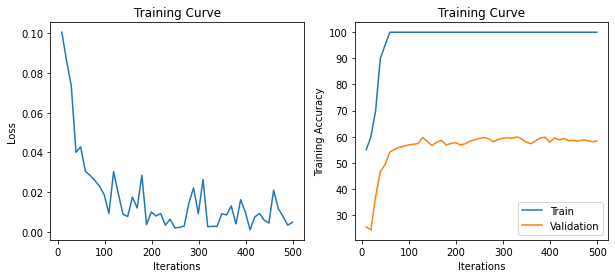

Final Training Accuracy: 100.0
Final Validation Accuracy: 58.35


In [ ]:
model = MNIST_Dropout()
train_model(model, train_set, val_set, weight_decay=0.001)

In [ ]:
# Answer the following questions
# Q7. What is the best validation accuracy and when was it achieved?

# The best validation accuracy is at 60 at around the 130th iteration.

# Q8. Is the validation accuracy a bit better with dropouts, normalisation and weight decay?

# The validation accuracy is a bit better with dropouts, normalization,
# and weight decay. The accuracy went from 56.4 to 58.35.

## Add Batch Norm
- Add batch norm BEFORE activation and dropout


In [ ]:
class MNIST_Dropout_BN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(28 * 28, 50)
        self.bn1 = nn.BatchNorm1d(num_features=50)
        self.layer2 = nn.Linear(50, 20)
        # Q9. Add a suitable batch norm layer here
        self.bn2 = nn.BatchNorm1d(num_features = 20)
        self.layer3 = nn.Linear(20, 10)
        self.dropout = nn.Dropout(0.4) # drop out layer with 40% dropped out neuron
    def forward(self, img):
        flattened = img.view(-1, 28 * 28)
        # Q10. Add batch norm to layer1 and layer2
        out1 = self.dropout(F.relu(self.bn1(self.layer1(flattened))))
        out2 = self.dropout(F.relu(self.bn2(self.layer2(out1))))
        output = self.layer3(out2)
        return output

Plotting


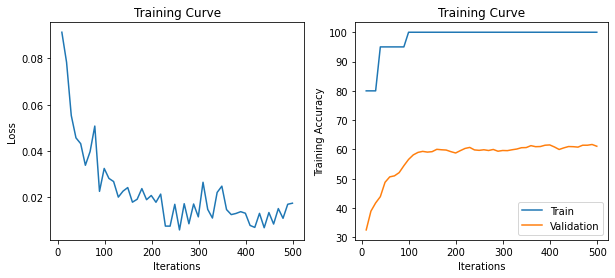

Final Training Accuracy: 100.0
Final Validation Accuracy: 61.1


In [ ]:
model = MNIST_Dropout_BN()
train_model(model, train_set, val_set, weight_decay=0.001)

### EXERCISE: Use Convolutions with Batch Norms
- Use the **same training and validation data** set loading as before, i.e. you do not have to load the data again
- Remember that BatchNorm1d accepts 2D or 3D inputs while BatchNorm2d only accepts 4D inputs
- Use BatchNorm2d with Conv2d layers
- Use Dropouts as well to get a model with better validation accuracy
- Plot the graph of your final training loss, training and validation accuracies (you may want to call `train_model()`)
- Extra: play around with the hyper parameters such as weight decay, learning, rate, etc. to help improve the model's performance


In [ ]:
class MNIST_Dropout_BN_CV(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(num_features =6)
        self.conv2 = nn.Conv2d(6, 12, 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(num_features = 12)
        self.conv3 = nn.Conv2d(12, 18, 3, padding = 1)
        self.dropout = nn.Dropout(0.4)


    def forward(self, img):
        out1 = self.dropout(F.relu(self.bn1(self.conv1(img))))
        out2 = self.dropout(F.relu(self.bn2(self.conv2(out1))))
        output = self.conv3(out2)
        return output

In [ ]:
model = MNIST_Dropout_BN_CV()
train_model(model, train_set, val_set, weight_decay=0.001)

RuntimeError: ignored